
# Polynomial Regression — Theory, Implementation, and Visualization

This notebook covers the **math behind polynomial regression**, a clean **NumPy implementation** (Normal Equation and Gradient Descent), **regularization (Ridge)**, **model selection** with simple **K-Fold cross‑validation**, and clear **visualizations**.



## Contents
1. Motivation and Setup
2. Mathematical Formulation
3. Regularization (Ridge)
4. Optimization (Normal Equation & Gradient Descent)
5. Bias–Variance and Overfitting
6. Implementation (NumPy)
7. Model Selection via K‑Fold CV
8. Visualizations
9. Conclusions



## 1. Motivation and Setup

Polynomial regression extends linear regression by using **polynomial basis functions** of the input.  
Even for a single scalar input $x \in \mathbb{R}$, we can model non‑linear relations by expanding to powers of $x$.

Given training data $\{(x_i, y_i)\}_{i=1}^n$, the goal is to approximate the functional relation between $x$ and $y$ while controlling overfitting.



## 2. Mathematical Formulation

Let $\phi(x)$ be a feature map (basis expansion). For **univariate** degree-$d$ polynomials, we use:
$$
\phi(x) = \big[\,1,\; x,\; x^2,\; \ldots,\; x^d \,\big]^\top.
$$

Collecting $n$ samples into the **design matrix** $X \in \mathbb{R}^{n \times (d+1)}$ where the $i$-th row is $\phi(x_i)^\top$, and the targets into $y \in \mathbb{R}^n$, our model is
$$
\hat{y} = X\theta,\quad \theta \in \mathbb{R}^{d+1}.
$$

We fit $\theta$ by minimizing the **mean squared error (MSE)**:
$$
\mathcal{L}(\theta) = \frac{1}{n}\,\|X\theta - y\|_2^2.
$$
The **normal equation** solution (when $X^\top X$ is invertible) is
$$
\theta^\star = \big(X^\top X\big)^{-1} X^\top y.
$$



## 3. Regularization (Ridge)

High‑degree polynomials can **overfit**. Ridge regression (L2 regularization) adds a penalty on large coefficients:
$$
\mathcal{L}_\lambda(\theta) = \frac{1}{n}\|X\theta - y\|_2^2 \;+\; \lambda \|\tilde{\theta}\|_2^2.
$$

Here $\lambda \ge 0$ and $\tilde{\theta}$ optionally **excludes** the bias term (set the first entry to zero). The closed‑form becomes
$$
\theta^\star_\lambda = \big(X^\top X + \lambda D\big)^{-1} X^\top y,
$$
where $D$ is a diagonal matrix (typically $D=\mathrm{diag}(0,1,1,\ldots,1)$ if not penalizing the bias).

**Gradient** of the unregularized loss is
$$
\nabla_\theta \mathcal{L}(\theta) = \frac{2}{n} X^\top(X\theta - y),
$$
and with Ridge it becomes
$$
\nabla_\theta \mathcal{L}_\lambda(\theta) = \frac{2}{n} X^\top(X\theta - y) + 2\lambda D\theta.
$$



## 4. Bias–Variance and Overfitting

Increasing degree $d$ increases model flexibility. Small $d$ can **underfit** (high bias), while large $d$ can **overfit** (high variance). A validation set or cross‑validation helps pick $d$ and $\lambda$ that generalize well.


In [2]:

# 5. Implementation Setup

import math
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, Optional, List, Callable
np.random.seed(42)

def train_val_split(X: np.ndarray, y: np.ndarray, val_ratio: float = 0.2, shuffle: bool = True) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    n = X.shape[0]
    idx = np.arange(n)
    if shuffle:
        np.random.shuffle(idx)
    n_val = int(np.floor(val_ratio * n))
    val_idx = idx[:n_val]
    tr_idx = idx[n_val:]
    return X[tr_idx], X[val_idx], y[tr_idx], y[val_idx]

def make_poly_features(x: np.ndarray, degree: int) -> np.ndarray:
    #Return Vandermonde-like design matrix for univariate x, degrees 0..degree.
    x = np.asarray(x).reshape(-1, 1)
    powers = [np.ones_like(x)]
    for d in range(1, degree + 1):
        powers.append(powers[-1] * x)  # iterative for numerical stability
    Phi = np.hstack(powers)  # shape (n, degree+1)
    return Phi

def mse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    return float(np.mean((y_true - y_pred) ** 2))

@dataclass
class PolyRegNormalEq:
    degree: int
    lam: float = 0.0
    penalize_bias: bool = False
    coef_: Optional[np.ndarray] = None  # shape (degree+1,)

    def fit(self, x: np.ndarray, y: np.ndarray) -> 'PolyRegNormalEq':
        X = make_poly_features(x, self.degree)
        y = y.reshape(-1, 1)
        D = np.eye(X.shape[1])
        if not self.penalize_bias:
            D[0, 0] = 0.0
        A = X.T @ X + self.lam * D
        b = X.T @ y
        self.coef_ = np.linalg.solve(A, b).reshape(-1)
        return self

    def predict(self, x: np.ndarray) -> np.ndarray:
        if self.coef_ is None:
            raise RuntimeError("Model not fitted yet.")
        X = make_poly_features(x, self.degree)
        return X @ self.coef_

@dataclass
class PolyRegGD:
    degree: int
    lam: float = 0.0
    penalize_bias: bool = False
    lr: float = 1e-2
    epochs: int = 5000
    coef_: Optional[np.ndarray] = None

    def fit(self, x: np.ndarray, y: np.ndarray) -> 'PolyRegGD':
        X = make_poly_features(x, self.degree)
        y = y.reshape(-1, 1)
        n, p = X.shape
        w = np.zeros((p, 1))
        D = np.eye(p)
        if not self.penalize_bias:
            D[0, 0] = 0.0

        for t in range(self.epochs):
            yhat = X @ w
            grad = (2.0 / n) * (X.T @ (yhat - y)) + 2.0 * self.lam * (D @ w)
            w -= self.lr * grad
        self.coef_ = w.reshape(-1)
        return self

    def predict(self, x: np.ndarray) -> np.ndarray:
        if self.coef_ is None:
            raise RuntimeError("Model not fitted yet.")
        X = make_poly_features(x, self.degree)
        return X @ self.coef_


In [3]:

# 6. Generate Synthetic Data (no external files)
# True function: y = sin(2*pi*x) + 0.3*x^3 with noise, x in [-1, 1]

n = 250
x = np.random.uniform(-1.0, 1.0, size=n)
def f_true(x):
    return np.sin(2 * np.pi * x) + 0.3 * (x ** 3)
noise = 0.15 * np.random.randn(n)
y = f_true(x) + noise

# Train/Val split
X_tr, X_val, y_tr, y_val = train_val_split(x.reshape(-1,1), y, val_ratio=0.25, shuffle=True)

print(f"Train size: {X_tr.shape[0]}, Val size: {X_val.shape[0]}")


Train size: 188, Val size: 62


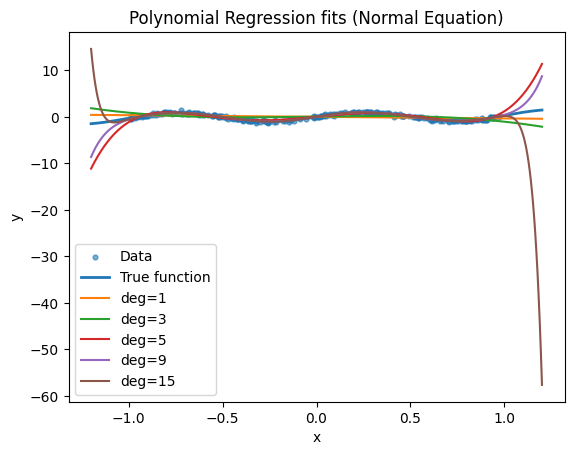

In [4]:

# 7. Fit several degrees with Normal Equation and visualize fits

degrees = [1, 3, 5, 9, 15]
lam = 0.0
grid = np.linspace(-1.2, 1.2, 400)

plt.figure()
plt.scatter(x, y, s=12, alpha=0.6, label="Data")
xx = grid
yy_true = f_true(xx)
plt.plot(xx, yy_true, linewidth=2, label="True function")

for d in degrees:
    model = PolyRegNormalEq(degree=d, lam=lam, penalize_bias=False).fit(X_tr.reshape(-1), y_tr)
    y_pred_grid = model.predict(xx)
    plt.plot(xx, y_pred_grid, linewidth=1.5, label=f"deg={d}")

plt.title("Polynomial Regression fits (Normal Equation)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


In [5]:

# 8. Simple K-Fold CV to choose degree and lambda

def kfold_indices(n: int, k: int, shuffle: bool = True):
    idx = np.arange(n)
    if shuffle:
        np.random.shuffle(idx)
    folds = np.array_split(idx, k)
    return folds

def kfold_cv_poly(x: np.ndarray, y: np.ndarray, degrees: List[int], lambdas: List[float], k: int = 5) -> Tuple[int, float, dict]:
    x = x.reshape(-1)
    y = y.reshape(-1)
    n = x.shape[0]
    folds = kfold_indices(n, k, shuffle=True)
    results = {}
    best = (None, None, float('inf'))  # degree, lambda, mse

    for d in degrees:
        for lam in lambdas:
            val_losses = []
            for i in range(k):
                val_idx = folds[i]
                tr_idx = np.hstack([folds[j] for j in range(k) if j != i])
                x_tr, x_val = x[tr_idx], x[val_idx]
                y_tr, y_val = y[tr_idx], y[val_idx]

                model = PolyRegNormalEq(degree=d, lam=lam, penalize_bias=False).fit(x_tr, y_tr)
                pred_val = model.predict(x[val_idx])
                val_losses.append(mse(y_val, pred_val))

            mean_val = float(np.mean(val_losses))
            results[(d, lam)] = mean_val
            if mean_val < best[2]:
                best = (d, lam, mean_val)
    return best[0], best[1], results

degrees_grid = list(range(0, 16))  # 0..15
lambdas_grid = [0.0, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]

best_d, best_lam, cv_results = kfold_cv_poly(x, y, degrees_grid, lambdas_grid, k=5)
print(f"Best degree: {best_d}, Best lambda: {best_lam:.4g}, CV-MSE: {cv_results[(best_d, best_lam)]:.5f}")


Best degree: 9, Best lambda: 0, CV-MSE: 0.02472


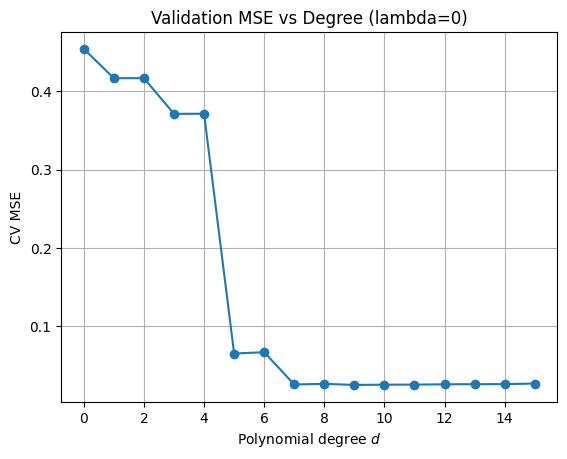

In [6]:

# 9. Plot validation MSE vs degree (for the chosen best lambda)

mses_vs_degree = []
for d in degrees_grid:
    mses_vs_degree.append(cv_results[(d, best_lam)])

plt.figure()
plt.plot(degrees_grid, mses_vs_degree, marker='o')
plt.xlabel("Polynomial degree $d$")
plt.ylabel("CV MSE")
plt.title(f"Validation MSE vs Degree (lambda={best_lam:.4g})")
plt.grid(True)
plt.show()


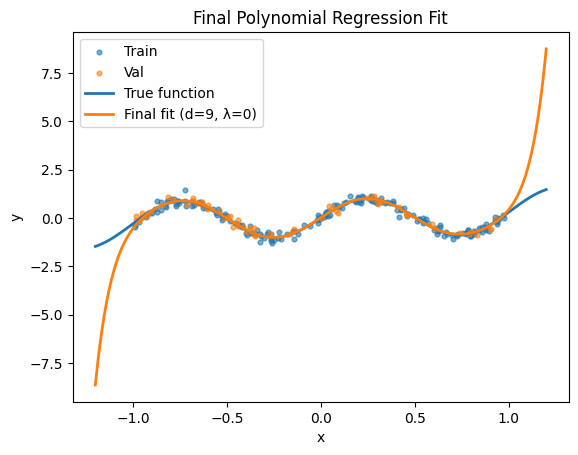

Train MSE: 0.021447171699042065
Val   MSE: 0.025283463006441673


In [7]:

# 10. Fit final model with (best_d, best_lam) and visualize

final_model = PolyRegNormalEq(degree=best_d, lam=best_lam, penalize_bias=False).fit(X_tr.reshape(-1), y_tr)
grid = np.linspace(-1.2, 1.2, 400)
y_final = final_model.predict(grid)

plt.figure()
plt.scatter(X_tr.reshape(-1), y_tr, s=12, alpha=0.6, label="Train")
plt.scatter(X_val.reshape(-1), y_val, s=12, alpha=0.6, label="Val")
plt.plot(grid, f_true(grid), linewidth=2, label="True function")
plt.plot(grid, y_final, linewidth=2, label=f"Final fit (d={best_d}, λ={best_lam:.4g})")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Final Polynomial Regression Fit")
plt.legend()
plt.show()

print("Train MSE:", mse(y_tr, final_model.predict(X_tr.reshape(-1))))
print("Val   MSE:", mse(y_val, final_model.predict(X_val.reshape(-1))))


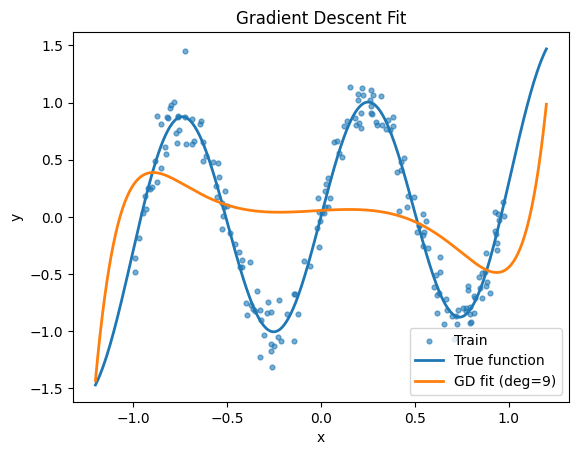

GD Train MSE: 0.3534633354226167
GD Val   MSE: 0.30834563472339044


In [8]:

# 11. (Optional) Gradient Descent optimization demo

gd_model = PolyRegGD(degree=min(12, best_d if best_d is not None else 8), lam=best_lam, lr=5e-3, epochs=4000)
gd_model.fit(X_tr.reshape(-1), y_tr)

plt.figure()
plt.scatter(X_tr.reshape(-1), y_tr, s=12, alpha=0.6, label="Train")
plt.plot(grid, f_true(grid), linewidth=2, label="True function")
plt.plot(grid, gd_model.predict(grid), linewidth=2, label=f"GD fit (deg={gd_model.degree})")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Gradient Descent Fit")
plt.legend()
plt.show()

print("GD Train MSE:", mse(y_tr, gd_model.predict(X_tr.reshape(-1))))
print("GD Val   MSE:", mse(y_val, gd_model.predict(X_val.reshape(-1))))
